In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os
import datetime
import pandas as pd

In [3]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import tensorboard
from torch.utils.tensorboard import SummaryWriter

In [4]:
from tqdm import tqdm

In [5]:
input_path = "./data/"
# csv_path = "./data/image_classification.csv"
csv_path = "./data/googleplaystore_sorted.csv"
df = pd.read_csv(csv_path)

In [6]:
# Initialize the summary writer
log_dir = os.path.join("logs", "fit", "csv_data", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)

In [9]:
# Log data from CSV to TensorBoard
# for index, row in df.iterrows():
#     writer.add_scalar('Metric/Column1', row['Reviews'], index)
#     writer.add_scalar('Metric/Column2', row['Installs'], index)
#     writer.add_scalar('Metric/Column3', row['Rating'], index)

table_str = df.to_markdown(index=False)
writer.add_text('CSV Data', table_str)

# Close the SummaryWriter
writer.close()

# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/csv_data


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
model = models.resnet152(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

c:\Users\Fady\anaconda3\envs\cudatest\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fady\anaconda3\envs\cudatest\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [32]:
train_loss = []
val_loss = []

train_acc = []
val_acc = []

In [33]:
def train_model(model, criterion, optimizer, num_epochs=50):
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                writer.add_scalar('Loss/validation', epoch_loss, epoch)
                writer.add_scalar('Accuracy/validation', epoch_acc, epoch)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [34]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train loss: 0.0651, acc: 0.9759


 10%|█         | 1/10 [02:05<18:48, 125.36s/it]

validation loss: 0.0026, acc: 1.0000
Epoch 2/10
----------
train loss: 0.0099, acc: 0.9975


 20%|██        | 2/10 [03:52<15:17, 114.73s/it]

validation loss: 0.0013, acc: 1.0000
Epoch 3/10
----------
train loss: 0.0307, acc: 0.9884


 30%|███       | 3/10 [05:34<12:40, 108.70s/it]

validation loss: 0.1477, acc: 0.9413
Epoch 4/10
----------
train loss: 0.0270, acc: 0.9900


 40%|████      | 4/10 [07:14<10:31, 105.29s/it]

validation loss: 0.0008, acc: 1.0000
Epoch 5/10
----------
train loss: 0.0022, acc: 0.9991


 50%|█████     | 5/10 [08:55<08:38, 103.79s/it]

validation loss: 0.0013, acc: 1.0000
Epoch 6/10
----------
train loss: 0.0037, acc: 0.9988


 60%|██████    | 6/10 [10:35<06:50, 102.57s/it]

validation loss: 0.0016, acc: 1.0000
Epoch 7/10
----------
train loss: 0.0069, acc: 0.9966


 70%|███████   | 7/10 [12:16<05:06, 102.13s/it]

validation loss: 0.0086, acc: 0.9938
Epoch 8/10
----------
train loss: 0.0054, acc: 0.9984


 80%|████████  | 8/10 [13:58<03:23, 101.99s/it]

validation loss: 0.0002, acc: 1.0000
Epoch 9/10
----------
train loss: 0.0048, acc: 0.9981


 90%|█████████ | 9/10 [15:38<01:41, 101.52s/it]

validation loss: 0.0001, acc: 1.0000
Epoch 10/10
----------
train loss: 0.0092, acc: 0.9966


100%|██████████| 10/10 [17:19<00:00, 103.94s/it]

validation loss: 0.0042, acc: 0.9962


In [35]:
val_acc_item = [i.item() for i in val_acc]
train_acc_item = [i.item() for i in train_acc]

In [36]:
# plt.figure(figsize=(10, 10))
# plt.subplot(1, 2, 1)
# plt.plot(train_loss, label='Train Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(frameon=False)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Curve')

# plt.subplot(1, 2, 2)
# plt.plot(train_acc_item, label='Train Accuracy')
# plt.plot(val_acc_item, label='Validation Accuracy')
# plt.legend(frameon=False)
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Curve')
# plt.show()

In [37]:
# Create the 'models' directory
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# Create the 'models/pytorch' subdirectory
pytorch_dir = os.path.join(models_dir, "pytorch")
os.makedirs(pytorch_dir, exist_ok=True)

print(f"Created directory: {models_dir}")
print(f"Created subdirectory: {pytorch_dir}")


Created directory: models
Created subdirectory: models\pytorch


In [38]:
torch.save(model_trained.state_dict(), './models/pytorch/weights.h5')

In [39]:
model = models.resnet152(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('./models/pytorch/weights.h5'))

c:\Users\Fady\anaconda3\envs\cudatest\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [40]:
validation_img_paths = ["validation/RefLightning/000_00084.jpg",
                        "validation/RefLightning/000_00820.jpg",
                        "validation/RenderedLightning/507_1.991_00153.jpg"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [41]:
img_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=428x612>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x323>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1080>]

In [42]:
img_list_rgb = []
for img in img_list:
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img_list_rgb.append(img)

In [43]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list_rgb])

In [44]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[  4.5978,  -5.9698],
        [  3.7799,  -5.2620],
        [-10.2336,   9.5719]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [45]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.9997425e-01, 2.5735695e-05],
       [9.9988163e-01, 1.1833417e-04],
       [2.5036857e-09, 1.0000000e+00]], dtype=float32)

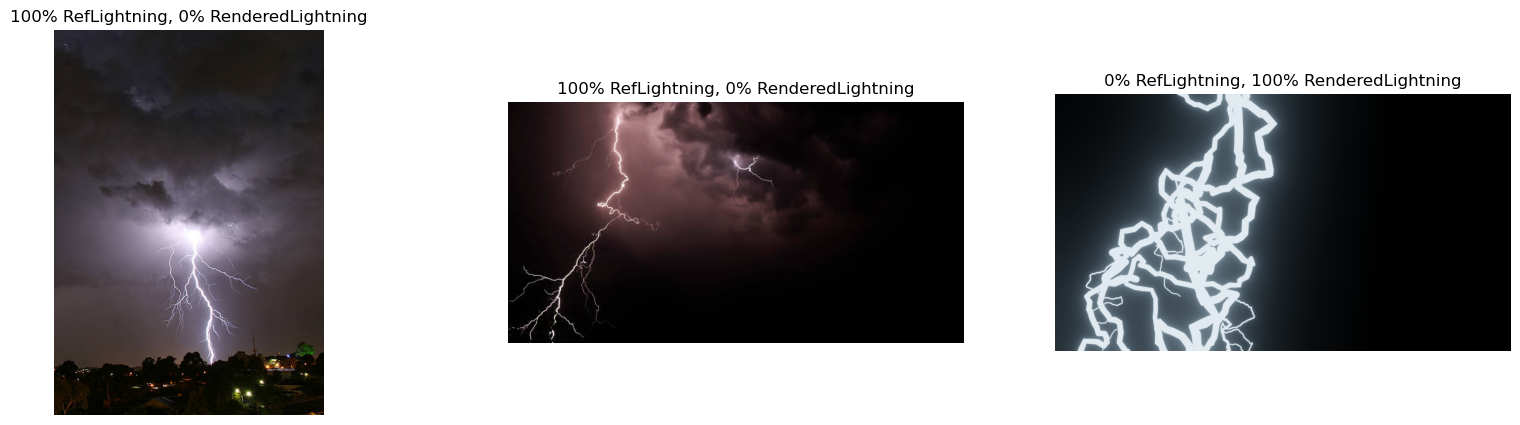

In [46]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% RefLightning, {:.0f}% RenderedLightning".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)